In [1]:
import pandas as pd
import pyarrow.parquet as pq
import pyarrow as pa # pyarrow 테이블 변환을 위해 임포트
import os

# (pyarrow 설치 필요: !pip install pyarrow)

SOURCE_FILE = 'df_master_preprocessed.parquet'
TARGET_FILE = 'df_filtered_2013_2017.parquet' # (새로 생성될 파일)
CHUNK_SIZE = 500000 # 한 번에 50만 행씩 읽기

# (Parquet 파일에 'date' 컬럼이 있는지 확인해야 함)
try:
    schema = pq.read_schema(SOURCE_FILE)
    if 'date' not in schema.names:
        print(f"오류: '{SOURCE_FILE}'에 'date' 컬럼이 없습니다.")
        print("EDA+Preprocessing 노트북에서 'date' 컬럼을 포함하여 다시 저장해야 합니다.")
    else:
        print(f"'{SOURCE_FILE}'에서 2013, 2017년 데이터 필터링 시작...")
        
        # 1. Parquet 파일 열기
        parquet_file = pq.ParquetFile(SOURCE_FILE)
        
        # 2. Parquet 파일 쓰기 준비 (TARGET_FILE)
        writer = None
        
        total_rows_processed = 0
        total_rows_saved = 0
        
        # 3. Chunk 단위로 반복 처리
        for i, batch in enumerate(parquet_file.iter_batches(batch_size=CHUNK_SIZE, columns=['date', 'style', 'country_brewery', 'abv', 'smell', 'taste', 'feel', 'score', 'username', 'beer_id'])):
            print(f"Processing chunk {i+1}...")
            
            # 3-1. Chunk를 Pandas DataFrame으로 변환
            chunk_df = batch.to_pandas()
            
            # 3-2. 날짜 변환 및 필터링
            chunk_df['datetime'] = pd.to_datetime(chunk_df['date'], errors='coerce')
            chunk_df['year'] = chunk_df['datetime'].dt.year
            
            filtered_chunk = chunk_df[chunk_df['year'].isin([2013, 2017])].copy()
            
            # (필터링된 데이터에서 불필요한 날짜 컬럼 제거)
            filtered_chunk = filtered_chunk.drop(columns=['datetime', 'year'])
            
            # 3-3. 필터링된 Chunk를 새 Parquet 파일에 추가
            if not filtered_chunk.empty:
                total_rows_saved += len(filtered_chunk)
                
                # PyArrow 테이블로 변환
                table_to_write = pa.Table.from_pandas(filtered_chunk, preserve_index=False)
                
                if writer is None:
                    # 첫 번째 Chunk는 스키마와 함께 쓰기 시작
                    writer = pq.ParquetWriter(TARGET_FILE, table_to_write.schema)
                
                writer.write_table(table_to_write)
                
            total_rows_processed += len(chunk_df)

        if writer:
            writer.close()
            print("\n--- 필터링 완료 ---")
            print(f"총 처리된 행: {total_rows_processed}")
            print(f"저장된 행 (2013/2017): {total_rows_saved}")
            print(f"필터링된 데이터가 '{TARGET_FILE}'에 저장되었습니다.")
        else:
            print("\n저장된 데이터가 없습니다. 'date' 컬럼이나 파일 경로를 확인하세요.")

except FileNotFoundError:
    print(f"오류: '{SOURCE_FILE}' 파일을 찾을 수 없습니다.")
except Exception as e:
    print(f"오류 발생: {e}")

'df_master_preprocessed.parquet'에서 2013, 2017년 데이터 필터링 시작...
Processing chunk 1...
Processing chunk 2...
Processing chunk 3...
Processing chunk 4...
Processing chunk 5...
Processing chunk 6...
Processing chunk 7...
Processing chunk 8...
Processing chunk 9...
Processing chunk 10...
Processing chunk 11...
Processing chunk 12...
Processing chunk 13...
Processing chunk 14...
Processing chunk 15...
Processing chunk 16...
Processing chunk 17...

--- 필터링 완료 ---
총 처리된 행: 8417033
저장된 행 (2013/2017): 1863769
필터링된 데이터가 'df_filtered_2013_2017.parquet'에 저장되었습니다.


In [23]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score

# 경고 메시지 무시
warnings.filterwarnings('ignore')

# --- 0. 하이퍼파라미터 ---
FILTERED_FILE = 'df_filtered_2013_2017.parquet' # (1단계 필터링 코드에서 생성된 파일)
SAMPLE_FRAC = 0.1 # (★중요★) 10% (0.1)로 시작. (이것도 터지면 0.05로 줄이세요)
K_BEERS = 6
K_USERS = 8
THRESHOLD = 0.2

In [24]:
# --- 1. (Pandas) 필터링된 데이터 로드 및 샘플링 ---
print(f"--- 1. 필터링된 데이터 로드 및 샘플링 (FRAC={SAMPLE_FRAC}) ---")
try:
    df_filtered = pd.read_parquet(FILTERED_FILE)
    print(f"필터링된 데이터 로드 성공. 크기: {df_filtered.shape}")
    
    # --- 2. (중요) 샘플링 ---
    # (예: 300만 행 -> 30만 행)
    df_sample = df_filtered.sample(frac=SAMPLE_FRAC, random_state=42)
    print(f"샘플링 완료. 최종 학습 데이터 크기: {df_sample.shape}")

    # (★중요★) 더 이상 원본 df_filtered는 필요 없으므로 메모리에서 즉시 삭제
    del df_filtered 
    print("메모리에서 원본 'df_filtered' (필터링된 전체 데이터)를 삭제했습니다.")
    
except FileNotFoundError:
    print(f"오류: '{FILTERED_FILE}'를 찾을 수 없습니다.")
    print("[1단계: 필터링 전용 코드]를 먼저 실행하여 Parquet 파일을 생성해야 합니다.")
except Exception as e:
    print(f"데이터 로드 중 오류 발생: {e}")

--- 1. 필터링된 데이터 로드 및 샘플링 (FRAC=0.1) ---
필터링된 데이터 로드 성공. 크기: (1863769, 10)
샘플링 완료. 최종 학습 데이터 크기: (186377, 10)
메모리에서 원본 'df_filtered' (필터링된 전체 데이터)를 삭제했습니다.


In [25]:
# --- 3. (EDA 노트북의) style_group, geo_group 피처 재생성 ---
print("\n--- 'style_group' 및 'geo_group' 피처 생성 중 ---")
def group_style(style):
    if 'IPA' in str(style): return 'IPA'
    if 'Stout' in str(style): return 'Stout'
    if 'Ale' in str(style): return 'Ale'
    return 'Other'
df_sample['style_group'] = df_sample['style'].apply(group_style)
    
def group_country(country):
    if country == 'US': return 'US'
    if country in ['DE', 'GB', 'BE']: return 'Europe'
    return 'Other'
df_sample['geo_group'] = df_sample['country_brewery'].apply(group_country)

print("'style_group', 'geo_group' 생성 완료.")
print(df_sample[['style', 'style_group', 'country_brewery', 'geo_group']].head())


--- 'style_group' 및 'geo_group' 피처 생성 중 ---
'style_group', 'geo_group' 생성 완료.
                          style style_group country_brewery geo_group
1353722  Russian Imperial Stout       Stout              US        US
1186834            American IPA         IPA              US        US
1855555            American IPA         IPA              US        US
541603           American Lager       Other              US        US
1116382   American Imperial IPA         IPA              US        US


In [26]:
# (NEW CELL) - Cell 4와 Cell 6 사이에 삽입하세요.
# --- 3-A. Latent Feature 추출 (SVD) ---

print("\n--- 3-A. Latent Feature 추출 (SVD) ---")

# 1. User-Item Rating Matrix 생성 (df_sample 사용)
# SVD는 NaN을 허용하지 않으므로 .fillna(0)으로 처리합니다.
try:
    rating_matrix = df_sample.pivot_table(index='username', columns='beer_id', values='score').fillna(0)
    # pivot_table 결과가 너무 클 수 있으므로 csr_matrix로 변환
    rating_sparse = csr_matrix(rating_matrix.values)
    
    # 2. SVD 수행
    N_COMPONENTS = 10 # (★중요★) Latent Factor 개수 (하이퍼파라미터)
    svd = TruncatedSVD(n_components=N_COMPONENTS, random_state=42)
    
    # User와 Beer의 잠재 요인 추출
    user_latent_factors = svd.fit_transform(rating_sparse)
    beer_latent_factors = svd.components_.T
    
    # 3. DataFrame으로 변환 (나중에 Merge하기 위함)
    # User Latent Factors (인덱스: username)
    user_latent_df = pd.DataFrame(
        user_latent_factors, 
        index=rating_matrix.index, 
        columns=[f'user_latent_{i}' for i in range(N_COMPONENTS)]
    )
    
    # Beer Latent Factors (인덱스: beer_id)
    beer_latent_df = pd.DataFrame(
        beer_latent_factors, 
        index=rating_matrix.columns, 
        columns=[f'beer_latent_{i}' for i in range(N_COMPONENTS)]
    )
    
    # beer_id가 인덱스에 있으므로, reset_index()로 컬럼으로 변환
    beer_latent_df = beer_latent_df.reset_index().rename(columns={'index': 'beer_id'})

    print(f"SVD 완료. User Latent Factors: {user_latent_df.shape}, Beer Latent Factors: {beer_latent_df.shape}")

except ValueError as e:
    print(f"SVD 수행 중 오류: {e}")
    print("df_sample에 데이터가 충분하지 않거나 메모리 문제일 수 있습니다.")
except Exception as e:
    print(f"알 수 없는 오류 발생: {e}")


--- 3-A. Latent Feature 추출 (SVD) ---
SVD 완료. User Latent Factors: (18116, 10), Beer Latent Factors: (37494, 11)


In [27]:
# --- 3-1. Beer 클러스터링 (새로 생성, abv 제외) ---
print("\n--- Beer Clustering (Pandas, abv 제외) ---")

# (1) 재료 준비: 'beer_id', 'style_group', 'geo_group'만 선택
beer_features_df = df_sample[['beer_id', 'style_group', 'geo_group']].drop_duplicates(subset=['beer_id']).set_index('beer_id')

# (2) ★★★ 요청하신 코드: 결측치(NaN) 체크 (가공 전) ★★★
print(f"Beer 클러스터링 재료(원본) NaN 개수 (총 {len(beer_features_df)}개 맥주):")
print(beer_features_df.isnull().sum())
print("-" * 30)

# (3) 재료 가공: style/geo가 NaN인 맥주는 클러스터링에서 제외
beer_features_df = beer_features_df.dropna()
print(f"NaN 제거 후 Beer 클러스터링 대상 맥주: {len(beer_features_df)}개")

# (4) 재료 가공: OneHotEncoding (텍스트 -> 0/1)
# (abv가 없으므로 StandardScaler는 필요 없음)
beer_features_cat = pd.get_dummies(beer_features_df[['style_group', 'geo_group']])
beer_features_processed = beer_features_cat.values 

# (5) K-Means 실행
kmeans_beer = KMeans(n_clusters=K_BEERS, random_state=42, n_init=10)
beer_features_df['beer_cluster'] = kmeans_beer.fit_predict(beer_features_processed)

print(f"\nBeer 클러스터링 완료. {K_BEERS}개 그룹으로 분류됨.")
print(beer_features_df['beer_cluster'].value_counts())


--- Beer Clustering (Pandas, abv 제외) ---
Beer 클러스터링 재료(원본) NaN 개수 (총 37494개 맥주):
style_group    0
geo_group      0
dtype: int64
------------------------------
NaN 제거 후 Beer 클러스터링 대상 맥주: 37494개

Beer 클러스터링 완료. 6개 그룹으로 분류됨.
beer_cluster
1    10298
2     9033
0     8048
5     3951
4     3920
3     2244
Name: count, dtype: int64


In [28]:
# (MODIFIED CELL 6) - User Clustering
print("\n--- User Clustering (Pandas + Latent Features) ---")

# (기존 코드)
user_style_affinity = pd.crosstab(df_sample['username'], df_sample['style_group'], normalize='index')
user_numeric_features = df_sample.groupby('username').agg(
    user_avg_score=('score', 'mean'),
    user_avg_abv=('abv', 'mean'),
    user_avg_smell=('smell', 'mean')
).fillna(0)

# (★★★★★ 수정된 부분 ★★★★★)
# 기존 user_profile_df에 SVD로 만든 user_latent_df를 결합합니다.
# user_latent_df는 SVD 셀에서 이미 생성되었다고 가정합니다.
if 'user_latent_df' in locals():
    user_profile_df = pd.concat([user_numeric_features, user_style_affinity, user_latent_df], axis=1).fillna(0)
    print("User profile에 Latent Features 결합 성공.")
else:
    print("Warning: user_latent_df가 없습니다. SVD 셀을 먼저 실행하세요.")
    user_profile_df = pd.concat([user_numeric_features, user_style_affinity], axis=1).fillna(0)
    
# (기존 코드)
scaler_user = StandardScaler()
user_features_processed = scaler_user.fit_transform(user_profile_df)
    
kmeans_user = KMeans(n_clusters=K_USERS, random_state=42, n_init=10)
user_profile_df['user_cluster'] = kmeans_user.fit_predict(user_features_processed)

user_profile_df = user_profile_df.reset_index() 

print(f"User 클러스터링 완료. {len(user_profile_df)}명의 유저가 {K_USERS}개 그룹으로 분류됨.")
print("User Profile Head:")
print(user_profile_df.head())


--- User Clustering (Pandas + Latent Features) ---
User profile에 Latent Features 결합 성공.
User 클러스터링 완료. 18116명의 유저가 8개 그룹으로 분류됨.
User Profile Head:
  username  user_avg_score  user_avg_abv  user_avg_smell       Ale       IPA  \
0  --Dom--        4.340667      9.953333        4.333333  0.200000  0.400000   
1     -DF-        3.740000      8.400000        3.750000  1.000000  0.000000   
2     -MK-        4.000000      8.650000        0.000000  0.500000  0.500000   
3  -NESTO-        3.970588      9.229412        0.000000  0.294118  0.235294   
4    -Rick        4.441429      9.571429        4.464286  0.000000  0.571429   

      Other     Stout  user_latent_0  user_latent_1  user_latent_2  \
0  0.133333  0.266667       3.554426      -0.649790       0.490806   
1  0.000000  0.000000       0.032705      -0.013641      -0.032236   
2  0.000000  0.000000       0.361756      -0.038011      -0.116913   
3  0.235294  0.235294       3.315072      -0.280576       0.448988   
4  0.285714  0.142857

In [29]:
# (MODIFIED CELL 7) - 최종 학습 데이터 생성
print("\n--- 최종 학습 데이터 생성 ---")

# SVD 셀에서 설정한 컴포넌트 개수와 동일하게 맞춰야 합니다.
N_COMPONENTS = 10 

# 1. df_sample + beer_cluster 병합
df_model = pd.merge(df_sample, beer_features_df[['beer_cluster']], on='beer_id', how='left')

# 2. (★★★★★ 핵심 수정 ★★★★★)
# user_profile_df에서 가져올 컬럼 목록을 동적으로 생성합니다.
user_cols_to_merge = ['username', 'user_cluster', 'user_avg_score']

# SVD 셀이 정상적으로 실행되었다면 user_latent 컬럼들을 추가합니다.
if f'user_latent_{N_COMPONENTS-1}' in user_profile_df.columns:
    user_latent_cols = [f'user_latent_{i}' for i in range(N_COMPONENTS)]
    user_cols_to_merge.extend(user_latent_cols)
    print(f"User profile에서 {len(user_latent_cols)}개의 User Latent Features를 병합 목록에 추가합니다.")
else:
    print("Warning: user_profile_df에 user_latent 컬럼이 없습니다. SVD 셀 또는 Cell 6을 확인하세요.")

# 3. df_model + user_profile 정보 병합
df_model = pd.merge(df_model, 
                    user_profile_df[user_cols_to_merge], 
                    on='username', 
                    how='left')
    
# 4. df_model + beer_latent 정보 병합
if 'beer_latent_df' in locals() and f'beer_latent_{N_COMPONENTS-1}' in beer_latent_df.columns:
    df_model = pd.merge(df_model, beer_latent_df, on='beer_id', how='left')
    print("최종 데이터에 Beer Latent Features 병합 성공.")
else:
    print("Warning: beer_latent_df가 없습니다. SVD 셀을 먼저 실행하세요.")

# 5. Target 변수 생성 (THRESHOLD는 0.5 또는 0.9 등으로 상향 조정 권장)
THRESHOLD = 0.5 
df_model['is_top_pick'] = (df_model['score'] > (df_model['user_avg_score'] + THRESHOLD)).astype(int)

print("'is_top_pick' 타겟 변수 생성 완료.")
print(df_model['is_top_pick'].value_counts(normalize=True))

# 6. (메모리 해제)
del df_sample
del beer_features_df
if 'user_profile_df' in locals(): del user_profile_df
if 'beer_latent_df' in locals(): del beer_latent_df
print("중간 데이터프레임 메모리 해제 완료.")


--- 최종 학습 데이터 생성 ---
User profile에서 10개의 User Latent Features를 병합 목록에 추가합니다.
최종 데이터에 Beer Latent Features 병합 성공.
'is_top_pick' 타겟 변수 생성 완료.
is_top_pick
0    0.879492
1    0.120508
Name: proportion, dtype: float64
중간 데이터프레임 메모리 해제 완료.


In [30]:
# (MODIFIED CELL 8) - Train/Test/Validation 분리
print("\n--- Train/Test/Validation 분리 ---")

# SVD 셀, Cell 7과 동일한 값
N_COMPONENTS = 10 

# 1. Content-Based + Cluster Features
features_to_use = [
    'smell', 'taste', 'feel',
    'style_group', 'geo_group',
    'beer_cluster', 'user_cluster'
]

# 2. Latent Features (CF)
user_latent_cols = [f'user_latent_{i}' for i in range(N_COMPONENTS)]
beer_latent_cols = [f'beer_latent_{i}' for i in range(N_COMPONENTS)]

features_to_use.extend(user_latent_cols)
features_to_use.extend(beer_latent_cols)

print(f"Latent Features ({len(user_latent_cols) + len(beer_latent_cols)}개)가 모델 피처에 추가되었습니다.")
print(f"--- 최종 모델에 사용될 피처 총 {len(features_to_use)}개 ---")

target = 'is_top_pick'
    
# 3. (오류 방지) df_model에 해당 컬럼들이 *모두* 존재하는지 확인
all_cols_needed = features_to_use + [target]
missing_cols = [col for col in all_cols_needed if col not in df_model.columns]

if missing_cols:
    print(f"!!! 오류: df_model에 다음 컬럼이 없습니다: {missing_cols}")
    print("!!! Cell 7의 merge 로직을 다시 확인하세요.")
else:
    # 4. SVD/Merge로 생성된 피처에 NaN이 있을 수 있으므로 dropna 수행
    df_model = df_model.dropna(subset=all_cols_needed) 
    print(f"결측치 제거 후 최종 학습 행: {len(df_model)}")
        
    X = df_model[features_to_use]
    y = df_model[target]
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    print(f"Train: {X_train_sub.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")

    # (★★★★★ 수정된 부분: LabelEncoder 사용 + Unseen Label 처리 ★★★★★)
    print("\n--- LabelEncoding 수행 (Unseen Label 처리 포함) ---")
    categorical_features_final = ['style_group', 'geo_group', 'beer_cluster', 'user_cluster']
    encoders = {} # 나중에 예측에 사용하기 위해 인코더 저장

    # (기존 LabelEncoding 코드...)
    # (Latent Feature는 숫자형이므로 LabelEncoding 대상이 아닙니다)
    for col in categorical_features_final:
        le = LabelEncoder()
        
        # (중요) Train/Val/Test에 있는 *모든* 고유 카테고리 목록을 만듭니다.
        # (astype(str)은 -1 같은 숫자도 문자로 통일하기 위함)
        all_categories = pd.concat([
            X_train_sub[col].astype(str), 
            X_val[col].astype(str), 
            X_test[col].astype(str)
        ]).unique()
        
        # "모든" 카테고리로 .fit()을 수행
        le.fit(all_categories)
        
        # Train/Val/Test 모두 .transform() 적용
        X_train_sub[col] = le.transform(X_train_sub[col].astype(str))
        X_val[col] = le.transform(X_val[col].astype(str))
        X_test[col] = le.transform(X_test[col].astype(str))
        encoders[col] = le

    print("범주형 피처 인코딩 완료 (int 타입으로 변환).")


--- Train/Test/Validation 분리 ---
Latent Features (20개)가 모델 피처에 추가되었습니다.
--- 최종 모델에 사용될 피처 총 27개 ---
결측치 제거 후 최종 학습 행: 78700
Train: (50368, 27), Validation: (12592, 27), Test: (15740, 27)

--- LabelEncoding 수행 (Unseen Label 처리 포함) ---
범주형 피처 인코딩 완료 (int 타입으로 변환).


In [31]:
# --- 3-6. XGBoost 학습 (Pandas) ---
print("\n--- XGBoost Hybrid 모델 학습 시작 ---")
hybrid_model_xgb = xgb.XGBClassifier(
    objective='binary:logistic', eval_metric='auc',
    n_estimators=1000, learning_rate=0.05, max_depth=6,
    n_jobs=-1, random_state=42,
    enable_categorical=True # (★중요★) [Cell 7]에서 만든 'int'를 'category'로 인식함
)
    
# (이제 이 코드가 정상적으로 실행됩니다.)
hybrid_model_xgb.fit(
    X_train_sub, y_train_sub,
    eval_set=[(X_val, y_val)],      
    early_stopping_rounds=50,      
    verbose=100
)

print("모델 학습 완료.")


--- XGBoost Hybrid 모델 학습 시작 ---
[0]	validation_0-auc:0.896548
Will train until validation_0-auc hasn't improved in 50 rounds.
[100]	validation_0-auc:0.932421
[200]	validation_0-auc:0.94445
[300]	validation_0-auc:0.95005
[400]	validation_0-auc:0.954371
[500]	validation_0-auc:0.957134
[600]	validation_0-auc:0.958504
[700]	validation_0-auc:0.95939
[800]	validation_0-auc:0.960063
[900]	validation_0-auc:0.960561
[999]	validation_0-auc:0.960789
모델 학습 완료.


In [32]:
# --- 3-7. 평가 ---
print("\n--- 모델 평가 (Test Set) ---")
preds_proba = hybrid_model_xgb.predict_proba(X_test)[:, 1]
preds_binary = hybrid_model_xgb.predict(X_test)
auc_score = roc_auc_score(y_test, preds_proba)

print(f"\n[Hybrid Model - Test Set 결과]")
print(f"AUC (Area Under Curve): {auc_score:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, preds_binary))


--- 모델 평가 (Test Set) ---

[Hybrid Model - Test Set 결과]
AUC (Area Under Curve): 0.9613

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     14218
           1       0.83      0.58      0.68      1522

    accuracy                           0.95     15740
   macro avg       0.90      0.78      0.83     15740
weighted avg       0.94      0.95      0.94     15740



In [35]:
# --- P@K, R@K 계산을 위한 사전 준비 ---

# 1. X_test (15740행)의 인덱스를 가져옵니다.
test_indices = X_test.index

# 2. X_test의 인덱스를 사용해 원본 df_model에서 'username'을 가져옵니다.
# (df_model이 del 되었다면, Cell 8의 X, y 분할 전에 df_model[['username']]을 따로 복사해 두어야 합니다.)
# 여기서는 df_model이 아직 메모리에 있다고 가정합니다.
# (만약 Cell 7에서 df_model을 del 했다면 Cell 7을 다시 실행해 df_model을 만들어야 합니다)

# (Cell 8을 다시 실행해야 할 수도 있습니다)
# df_model = df_model.dropna(subset=all_cols_needed)
# X = df_model[features_to_use]
# y = df_model[target]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train_sub, X_val, y_train_sub, y_val = ...

# (Cell 10 이후)
# X_test (피처)
# y_test (실제 값: 0 또는 1)
# hybrid_model_xgb (학습된 모델)

# 3. Test Set에 대한 'username', '실제값', '예측 확률'을 하나의 DataFrame으로 결합
test_results_df = df_model.loc[y_test.index, ['username']].copy()
test_results_df['is_top_pick_true'] = y_test
test_results_df['probability_top_pick'] = hybrid_model_xgb.predict_proba(X_test)[:, 1]

print("P@K 계산 준비 완료:")
print(test_results_df.head())

P@K 계산 준비 완료:
           username  is_top_pick_true  probability_top_pick
142345    Chadbeer7                 1              0.813553
136748   mintjellie                 0              0.006866
97954     Gagnonsux                 1              0.269359
153044  StoutElk_92                 0              0.006983
90778   Gkruszewski                 0              0.002250


In [36]:
def calculate_ranking_metrics(df_results, k=10):
    """
    K=10일 때의 Precision@K, Recall@K, MAP@K를 계산합니다.
    
    Args:
    df_results (pd.DataFrame): 'username', 'is_top_pick_true', 'probability_top_pick' 컬럼 필요.
    k (int): 상위 몇 개를 추천 리스트로 볼 것인지 결정.
    """
    
    user_groups = df_results.groupby('username')
    
    user_metrics = {
        'precision@k': [],
        'recall@k': [],
        'map@k': []
    }
    
    for username, group in user_groups:
        # 1. 실제 Top Pick이 하나도 없는 유저는 평가에서 제외 (Recall 계산 불가)
        total_true_positives = group['is_top_pick_true'].sum()
        if total_true_positives == 0:
            continue
            
        # 2. 예측 확률 순으로 정렬 (추천 리스트 생성)
        top_k_list = group.sort_values('probability_top_pick', ascending=False).head(k)
        
        # 3. K개 리스트 중 실제 Top Pick 개수 (Hits)
        hits_df = top_k_list[top_k_list['is_top_pick_true'] == 1]
        num_hits = len(hits_df)
        
        # 4. P@K, R@K 계산
        precision_at_k = num_hits / k
        recall_at_k = num_hits / total_true_positives
        
        user_metrics['precision@k'].append(precision_at_k)
        user_metrics['recall@k'].append(recall_at_k)
        
        # 5. MAP@K (Mean Average Precision) 계산
        if num_hits > 0:
            # 리스트 중 'Hit'의 순위를 가져옴 (1부터 시작)
            hit_ranks = (top_k_list.reset_index(drop=True).index + 1)[top_k_list['is_top_pick_true'] == 1]
            
            # (1/1위) + (2/3위) + (3/7위) ...
            ap_sum = (pd.Series(range(1, num_hits + 1)) / hit_ranks).sum()
            average_precision = ap_sum / num_hits 
            user_metrics['map@k'].append(average_precision)
        else:
            user_metrics['map@k'].append(0.0)

    # 모든 유저의 평균을 반환
    if not user_metrics['precision@k']:
        print("Warning: 평가 가능한 유저가 없습니다 (Test Set에 실제 Top Pick이 없음).")
        return pd.Series(index=['precision@k', 'recall@k', 'map@k'], data=[0.0, 0.0, 0.0])
        
    return pd.Series(user_metrics).apply(np.mean)

# K=5, K=10일 때의 랭킹 지표 계산
print("\n--- 랭킹 평가 지표 (Test Set) ---")
k_5_metrics = calculate_ranking_metrics(test_results_df, k=5)
print(f"\n[Metrics @ K=5]\n{k_5_metrics}")

k_10_metrics = calculate_ranking_metrics(test_results_df, k=10)
print(f"\n[Metrics @ K=10]\n{k_10_metrics}")


--- 랭킹 평가 지표 (Test Set) ---

[Metrics @ K=5]
precision@k    0.271560
recall@k       0.995394
map@k          0.989317
dtype: float64

[Metrics @ K=10]
precision@k    0.139083
recall@k       0.999611
map@k          0.988982
dtype: float64



Saved 'feature_importance.png'


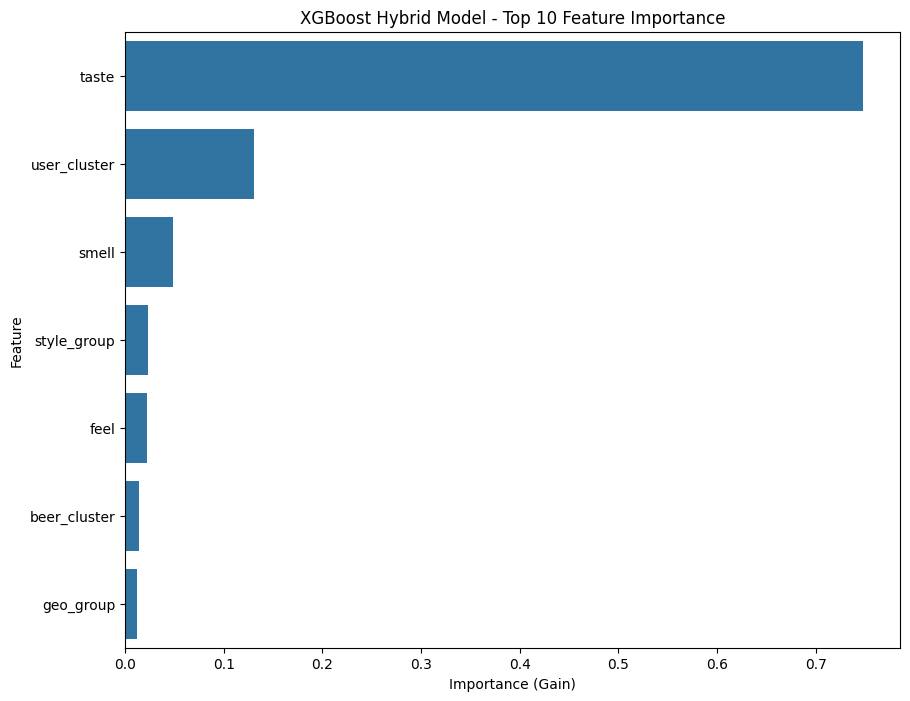

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# (X_train_sub, hybrid_model_xgb가 학습된 상태라고 가정)

# 1. 피처 중요도 추출
feature_importance = hybrid_model_xgb.feature_importances_
feature_names = X_train_sub.columns

# 2. DataFrame으로 정렬
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# 3. 시각화
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10)) # 상위 10개
plt.title('XGBoost Hybrid Model - Top 10 Feature Importance')
plt.xlabel('Importance (Gain)')
plt.ylabel('Feature')
plt.savefig('feature_importance.png')
print("\nSaved 'feature_importance.png'")